## Intensity filtered data using reference aluminium wavelength 309.506 (pixel number 445) using saturated data

### No preprocessing

In [1]:
import os
from sys import stdout
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.linear_model import ElasticNet,ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    
    return
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
"""   
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        plt.show()
    return
""" 

"   \n    # Fit a line to the CV vs response\n    z = np.polyfit(y, y_c, 1)\n    with plt.style.context(('ggplot')):\n        fig, ax = plt.subplots(figsize=(9, 5))\n        ax.scatter(y_c, y, c='red', edgecolors='k')\n        #Plot the best fit line\n        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)\n        #Plot the ideal 1:1 line\n        ax.plot(y, y, color='green', linewidth=1)\n        plt.title('$R^{2}$ (CV): '+str(score_cv))\n        plt.xlabel('Predicted $^{\\circ}$Brix')\n        plt.ylabel('Measured $^{\\circ}$Brix')\n        plt.show()\n    return\n"

In [3]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
    Xc = X[:,sorted_ind]
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [4]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [5]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

In [6]:
x_df = pd.read_csv('../avg_base_wl_25-02.csv', sep = ',')
values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

#print(values)
#print(type(values))
print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(24, 1446)
(1446,)
24


,252.071400,252.201700,252.331900,252.462200,252.592400,252.722600,252.852900,252.983100,253.113300,253.243600,...,428.718100,428.828600,428.939000,429.049500,429.159900,429.270300,429.380600,429.491000,429.601300,429.711600
0,-7.864691,-32.876223,-81.441809,34.100714,-8.329733,-6.084499,39.106688,81.595182,28.367469,-33.549423,...,131.632928,476.037019,1355.860070,1037.412886,289.114382,45.829415,-58.928506,-100.591822,-116.011889,-77.283306
1,-122.419869,-121.975190,-183.580510,-67.385822,-101.341118,-128.096389,-70.851622,-19.806804,-76.861917,-136.066946,...,29.233677,-61.440166,-92.663913,-100.237583,-59.411193,-46.334756,-129.158287,-148.631798,-188.155299,-161.378796
2,-45.938542,-72.597810,-135.657078,-23.249675,-63.075597,-82.768172,-43.860727,14.513414,-45.112407,-88.838180,...,49.048043,-37.678755,-49.138825,-56.865513,-6.225495,-13.052112,-82.745375,-108.538624,-121.998532,-110.125106
3,-74.248689,-88.550836,-140.577119,-24.499950,-75.181390,-101.449020,-59.647659,-6.122125,-58.286200,-98.795044,...,29.181529,-47.446362,-38.177626,-59.701933,-11.295156,-35.509030,-105.136672,-132.660848,-151.702258,-129.226424
4,113.773646,44.218164,13.704347,151.315527,114.676703,158.579536,294.774023,290.760158,130.579601,11.149013,...,30.602823,-51.837138,-114.277028,-83.466863,-16.073320,-37.513078,-93.661145,-119.142531,-138.832243,-109.605286
5,117.523648,28.773685,-0.176279,167.373754,123.123781,157.073801,315.248808,282.623796,105.123761,-5.851304,...,41.124975,-28.011700,-8.773303,-20.259847,-13.946342,-29.982800,-112.469232,-134.580649,-150.592057,-119.403464
6,-46.131274,-59.723018,-111.939761,0.843499,-32.623234,-61.964955,-21.556660,9.601659,-43.864994,-99.831611,...,66.274575,-27.007751,-51.790034,-48.197283,8.395497,13.238299,-57.418883,-87.451055,-95.233222,-76.265387
7,-34.186038,-55.433807,-97.281576,7.020658,-47.677101,-45.024852,3.477412,31.929696,-16.517996,-75.215658,...,79.536750,-14.535058,-18.406821,-4.628546,20.449761,1.178094,-55.443555,-86.315192,-112.586823,-92.858452
8,81.436124,17.374412,-15.946560,126.436168,100.189261,133.164567,238.250968,250.374384,130.719991,26.658148,...,97.588563,8.412306,0.680512,-12.421637,27.142895,21.374104,-32.246530,-35.719011,-66.747045,-31.034337
9,242.174780,126.912135,124.316155,319.220170,283.457508,373.094829,579.232128,543.736064,286.139963,152.310485,...,67.471440,-23.401227,-49.440521,-47.779784,-3.185688,-0.991572,-39.530775,-73.369968,-94.842491,-64.815013


[252.0714 252.2017 252.3319 ... 429.491  429.6013 429.7116]


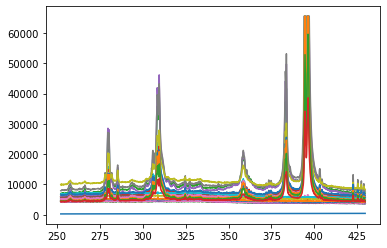

In [7]:
#This is just for visualizing the various plots of the samples

df = pd.read_csv('../ref_new/1.csv')
data=df.values
wl= data[0]
print(wl)

for i in range(len(values)):
    plt.plot(wl, data[i,:])
    #plt.show() #comment this one to have unique plot instead of multiple ones
#range(len(dfs))
#"""



In [8]:
df_y = pd.read_csv('../concentration_1.csv', sep = ',')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

y_values=df_y.values
y_all=pd.DataFrame(y_values[:,1:-2])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(24, 9)


,Reference Number,Si,Fe,Mg,Zn,Cu,Mn,Al,Total
0,1,0.185,0.228,2.940,0.0304,0.0620,0.280,96.0000,99.7254
1,2,0.360,0.600,1.100,0.0700,0.2000,0.830,96.5787,99.7387
2,3,9.140,1.010,0.200,0.4200,3.6000,0.410,84.7770,99.5570
3,4,8.565,0.000,0.293,0.8870,2.6360,0.330,86.5650,99.2760
4,5,9.500,0.000,0.391,0.0000,0.0580,0.016,90.0210,99.9860
5,6,7.220,0.140,0.360,0.0840,0.1200,0.053,91.8090,99.7860
6,7,7.460,0.530,0.036,0.1400,0.1500,0.100,91.4140,99.8300
7,8,12.900,0.120,0.520,0.1550,0.5200,0.286,84.7905,99.2915
8,9,8.750,0.460,1.710,0.0290,2.0000,0.056,85.3100,98.3150
9,10,0.260,0.420,1.260,0.0200,0.0040,1.160,96.8346,99.9586


In [9]:
y_val = concentration[:,3] #1-Si, 2-Fe, 3-Mg, 5-Cu, 6-Mn (4-Zn but too much sparse)
print(y_val)
print(y_val.shape)
y_df= pd.DataFrame(y_val)
#y_df

[2.94  1.1   0.2   0.293 0.391 0.36  0.036 0.52  1.71  1.26  0.41  0.88
 0.32  0.025 0.77  4.54  0.57  0.39  3.57  0.339 0.363 2.48  1.11  2.03 ]
(24,)


### Wavelength subset selection

For Silicon (Si) the peaks are at **251.59, 288.12, 390.60**

For Magnesium (Mg) the peaks are at **277.91, 279.59, 280.23, 281.78, 383.74, 285.27**

For Manganese (Mn) the peaks are at **292.83, 293.61, 294.91, 403.25, 404.63, 404.56**

In [69]:
print(wl.T)
print(wl.shape)
#print(len(wl))
print(wl[-1])

[252.0714 252.2017 252.3319 ... 429.491  429.6013 429.7116]
(1446,)
429.7116


In [70]:
#target = [251.59, 288.12, 390.60] #peaks for Si
#target = [277.91, 279.59, 280.23, 281.78, 383.74, 285.27] #peaks for Mg
target = [277.91, 279.59, 280.23, 281.78, 383.74, 285.27] #peaks for Mn
target = [292.83, 293.61, 294.91, 403.25, 404.63, 404.56]

In [72]:
a = []
b = []
for t in target:
    for i in range(len(wl)):
        if abs(wl[i]-t) < 0.5:
            a.append(wl[i])
            b.append(i)
            
print("number of selected wavelengths: ",len(a), "\n")
print(a, "\n")
print(b)

number of selected wavelengths:  49 

[292.3509, 292.4795, 292.608, 292.7366, 292.8651, 292.9937, 293.1222, 293.2507, 293.1222, 293.2507, 293.3792, 293.5077, 293.6362, 293.7647, 293.8932, 294.0217, 294.5355, 294.6639, 294.7923, 294.9207, 295.0492, 295.1776, 295.306, 402.782, 402.8978, 403.0136, 403.1294, 403.2452, 403.361, 403.4767, 403.5924, 403.7081, 404.1707, 404.2863, 404.4019, 404.5174, 404.6329, 404.7484, 404.8639, 404.9794, 405.0948, 404.1707, 404.2863, 404.4019, 404.5174, 404.6329, 404.7484, 404.8639, 404.9794] 

[311, 312, 313, 314, 315, 316, 317, 318, 317, 318, 319, 320, 321, 322, 323, 324, 328, 329, 330, 331, 332, 333, 334, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226]


In [73]:
print(values.shape)
print(values[:, b].shape)
x_selecta = pd.DataFrame(values[:, b])
x_selecta

(24, 1446)
(24, 49)


,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,324.786822,267.806451,383.099842,518.585940,674.291798,629.379606,598.471009,582.444413,598.471009,582.444413,...,1003.556219,941.612182,1532.710347,1431.896750,1661.666829,2125.101667,2119.471536,1533.560223,1238.246107,1003.556219
1,47.823109,-25.186129,16.805569,93.048239,123.341917,104.886641,170.232446,267.179368,170.232446,267.179368,...,651.894795,578.533286,1306.469662,1027.984783,1091.503155,1530.874806,1709.599765,1193.978064,928.359731,651.894795
2,140.772982,51.343809,112.348916,164.755003,222.195435,154.470244,240.246126,335.223111,240.246126,335.223111,...,882.264306,784.578131,1656.028665,1285.827266,1248.394683,1534.330924,1666.535999,1299.009915,1115.219348,882.264306
3,55.669422,-16.793369,49.296660,109.422311,147.721555,84.815124,154.392711,252.799181,154.392711,252.799181,...,666.152689,613.056257,1298.342442,1012.746790,1038.808597,1296.665816,1375.146054,1025.318299,868.665331,666.152689
4,107.028244,24.177388,63.578992,113.233083,158.056355,69.090501,46.293878,47.874844,46.293878,47.874844,...,603.431257,589.196095,818.869165,784.748649,928.004573,1167.345285,1271.562463,912.531120,740.376269,603.431257
5,112.039800,18.512646,58.211889,109.512558,113.814681,22.468287,9.248398,-2.869959,9.248398,-2.869959,...,628.339348,626.718623,848.963673,840.385748,987.808804,1215.507856,1294.107920,907.034013,757.086150,628.339348
6,71.134074,-7.377601,64.236149,90.350354,149.215045,77.580251,45.196001,68.312327,45.196001,68.312327,...,347.825919,317.444222,500.381906,470.091833,602.681464,783.400819,827.999920,536.603790,407.087449,347.825919
7,247.260311,172.886193,268.166849,389.752286,563.092515,543.787541,516.337372,482.892014,516.337372,482.892014,...,512.925789,482.534817,853.249413,743.224310,844.204051,1137.638647,1205.878108,831.272445,652.221668,512.925789
8,225.731803,168.734401,229.478192,292.111371,366.226571,275.786800,229.495803,193.205473,229.495803,193.205473,...,959.847414,901.899177,1302.533513,1304.508302,1615.674002,2108.475052,2090.207740,1447.353540,1141.356891,959.847414
9,219.761577,152.778203,211.396030,263.915096,316.502107,209.590433,222.013446,241.937846,222.013446,241.937846,...,1048.160385,966.445677,1565.294231,1462.055071,1854.186098,2553.053969,2464.425343,1701.800209,1319.378559,1048.160385


In [74]:
#X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 49) (19, 1)
(5, 49) (5, 1)
       0
9   1.26
23  2.03
16  0.57
15  4.54
14  0.77


# Principal Components Analysis

In [75]:
n_components=15


x = x_df.values
x= x_selecta.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

principalComponents = pca.fit_transform(X_std)
print(principalComponents.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(pca.singular_values_)

(24, 49)
(49,)
24
(24, 15)
[ 51.26  92.18  98.62  99.38  99.67  99.85  99.9   99.94  99.96  99.97
  99.98  99.99 100.   100.01 100.01]


In [76]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(principalComponents, y_df)
# Calibration
y_c = regr.predict(principalComponents)
# Cross-validation
y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_df, y_c)
score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation

mse_c = mean_squared_error(y_df, y_c)
mse_cv = mean_squared_error(y_df, y_cv)

print(score_c, score_cv)
print(mse_c, mse_cv)

0.8193206528268291 -3.6348399185065796
0.24670376354534232 6.328517726100955


now using PCA with Linear regression and PLS

In [77]:
n_components=15

x = X_train.values
x_t = X_test.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
X_std_test = StandardScaler().fit_transform(x_t)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

x_pc = pca.fit_transform(X_std)
x_test1 = pca.transform(X_std_test)
print(x_pc.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

(19, 49)
(49,)
19
(19, 15)
[53.57 92.6  98.86 99.52 99.78 99.9  99.94 99.96 99.97 99.98 99.99 99.99
 99.99 99.99 99.99]


In [78]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(x_pc, y_train)
# Calibration
y_p = regr.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_p)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_p)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  0.23282200803208297
MSE:  1.5988173475329464


37% completed
Suggested number of components:  1



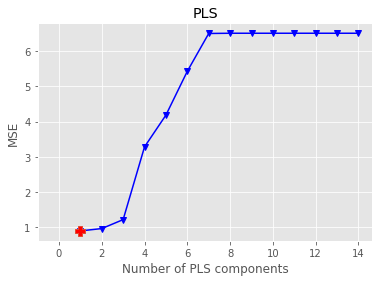

R2 calib: 0.954
R2 CV: 0.114
MSE calib: 0.046
MSE CV: 0.887


In [79]:
optimise_pls_cv(x_pc, y_train, 15, plot_components=True) 

In [80]:
pls = PLSRegression(n_components=3)
# Fit
pls.fit(x_pc, y_train)
# Calibration
y_c = pls.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_c)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_c)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  0.23282200803208863
MSE:  1.5988173475329348


# Linear Regression
this is ordinary least square regression

R^2_pred:  -2.9864900604819584
RMSE:  2.8823499027366286 

[real, predictions]
[[ 1.26        5.29365663]
 [ 2.03       -1.56006989]
 [ 0.57        0.74122197]
 [ 4.54        2.32593623]
 [ 0.77       -1.95934459]]


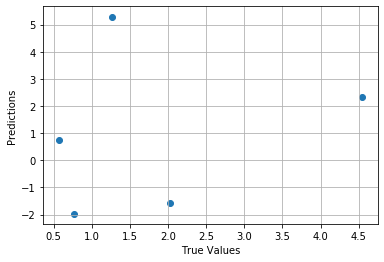

In [81]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("R^2_pred: ", r2)
print("RMSE: ", rmse, "\n")


b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Partial Least Square Regression

## No preprocessing

In [82]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)
y_test

(19, 49) (19, 1)
(5, 49) (5, 1)


,0
11,0.88
18,3.57
12,0.32
21,2.48
23,2.03


100% completed
Suggested number of components:  3



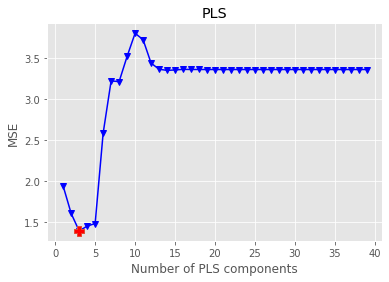

R2 calib: 0.544
R2 CV: -0.023
MSE calib: 0.623
MSE CV: 1.397


In [83]:
optimise_pls_cv(x_df, y_df, 40, plot_components=True)
#optimise_pls_cv(x_df, y_all, 40, plot_components=True)

In [84]:
# Define PLS object
pls = PLSRegression(n_components=3)
# Fit
pls.fit(x_df, y_df)
# Cross-validation
y_cv = cross_val_predict(pls, x_df, y_df, cv=10)
# Calculate scores
score = r2_score(y_df, y_cv)
mse = mean_squared_error(y_df, y_cv)

print("R^2_cv", score)
print("MSE: ", mse)

R^2_cv -0.022789294794738568
MSE:  1.396540181750316


In [85]:
#optimise_pls_cv(X_train,y_train, 40, plot_components=True)

R2_pred:  -1.394537515257599
R2_cv:  -1.8125121715369694

TEST
 [real, predictions]
[[0.88       0.65565856]
 [3.57       0.29607917]
 [0.32       0.26272467]
 [2.48       1.63600272]
 [2.03       4.14788536]]



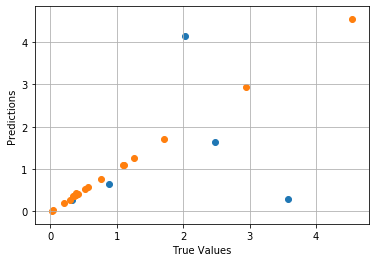

In [86]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [26]:
print(wl.shape)

(1446,)


## Wavelenght selection for PLS

In [87]:
print("x_selecta shape: ", x_selecta.shape)
start_time = time.time()

#opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_val, 15)
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_selecta.values, y_val, 25)

print("--- %s seconds ---" % (time.time() - start_time))

x_selecta shape:  (24, 49)
100% completed
Optimised number of PLS components:  19
Wavelengths to be discarded  23
Optimised MSEP  0.9896947227713749

--- 11.15535831451416 seconds ---


In [88]:
#print(opt_Xc.shape,"\n")
#print("sorted indexes: ", sorted_ind)
print("sorted wavelengths: ", wl[sorted_ind[:10]].T)

#plt.plot(opt_Xc.T)
#plt.show()

sorted wavelengths:  [255.8473 255.587  258.1893 257.0185 253.6342 255.0663 254.2852 257.7991
 256.6281 252.8529]


In [89]:
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =16
X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 26) (19, 1)
(5, 26) (5, 1)
       0
22  1.11
12  0.32
17  0.39
15  4.54
14  0.77


7% completed
Suggested number of components:  2



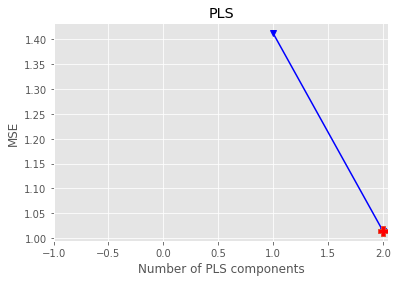

R2 calib: 0.256
R2 CV: 0.017
MSE calib: 0.768
MSE CV: 1.014


In [90]:
optimise_pls_cv(X_train,y_train, 3, plot_components=True)

R2_pred:  0.7063869967761478
RMSE:  0.8575694771544311

TEST
 [real, predictions]
[[ 1.11        1.68081825]
 [ 0.32        1.09267019]
 [ 0.39        1.1559451 ]
 [ 4.54        3.34948863]
 [ 0.77       -0.09619001]]



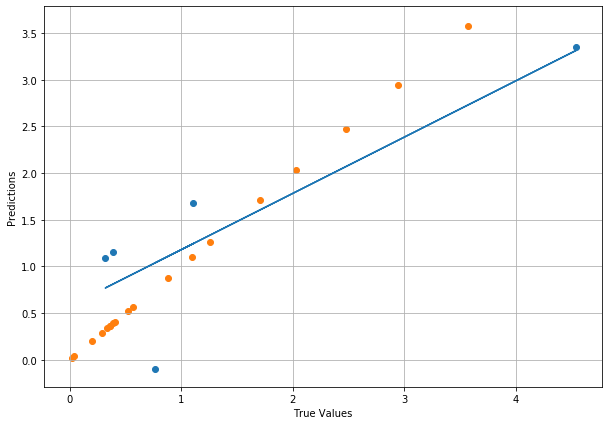

In [92]:
# Define PLS object
pls = PLSRegression(n_components=17)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Normalization

In [93]:
Xn_train = normalize(X_train, axis=1)
Xn_test = normalize(X_test, axis=1)
print(Xn_train.shape)
print(Xn_test.shape)

(19, 26)
(5, 26)


In [94]:
#plt.plot(Xn_train.T)
#plt.show()

In [95]:
#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xn_train,y_train, 3, plot_components=True)

R2_pred:  0.17672465964828665
RMSE:  1.435999292859823

TEST
 [real, predictions]
[[ 1.11        2.14286454]
 [ 0.32        0.55521574]
 [ 0.39        1.76396664]
 [ 4.54        2.77158671]
 [ 0.77       -1.27285691]]



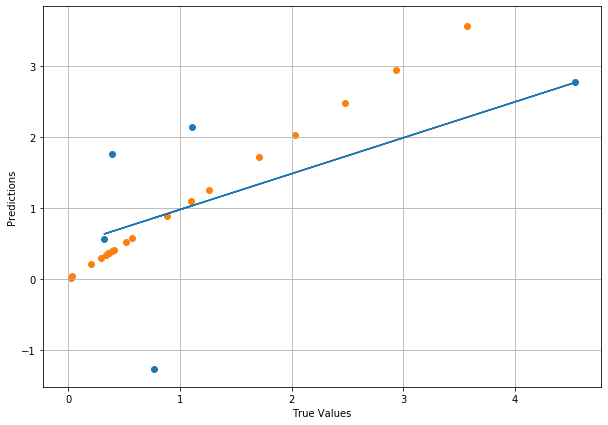

In [97]:
# Define PLS object
pls = PLSRegression(n_components=17)
# Fit
pls.fit(Xn_train, y_train)

y_pred = pls.predict(Xn_test)
y_pred1 = pls.predict(Xn_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using SNV

In [98]:
Xs_train = snv(X_train)
Xs_test = snv(X_test)
print(Xs_train.shape)
print(Xs_test.shape)

#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xs_train,y_train, 7, plot_components=True)

(19, 26)
(5, 26)


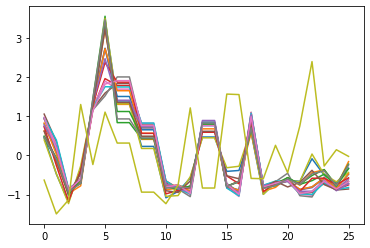

In [99]:
plt.plot(Xs_train.T)
plt.show()

R2_pred:  -0.210082538180985
RMSE:  1.7409615093429243

TEST
 [real, predictions]
[[1.11       1.39299453]
 [0.32       0.93648681]
 [0.39       1.08407408]
 [4.54       0.77310257]
 [0.77       0.92276751]]



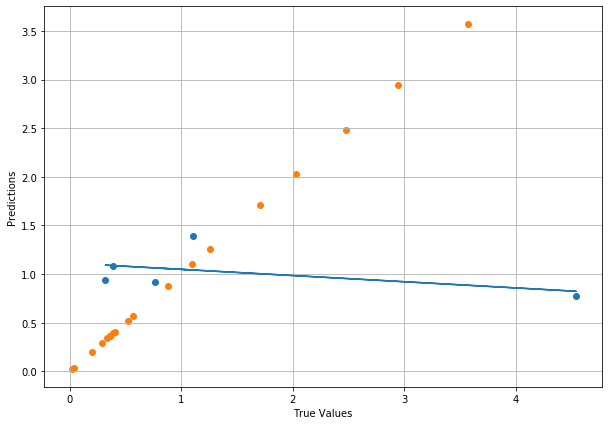

In [102]:
# Define PLS object
pls = PLSRegression(n_components=18)
# Fit
pls.fit(Xs_train, y_train)

y_pred = pls.predict(Xs_test)
y_pred1 = pls.predict(Xs_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Max-norm

In [103]:
Xm_train = X_train / np.max(X_train)
Xm_test = X_test / np.max(X_test)

#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xm_train,y_train, 7, plot_components=True)

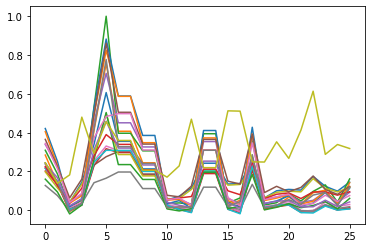

In [104]:
plt.plot(Xm_train.T)
plt.show()

R2_pred:  0.6665543772037594
RMSE:  0.9138905421466769

TEST
 [real, predictions]
[[ 1.11        2.09479535]
 [ 0.32        1.28134559]
 [ 0.39        1.36619018]
 [ 4.54        4.44651749]
 [ 0.77       -0.37903704]]



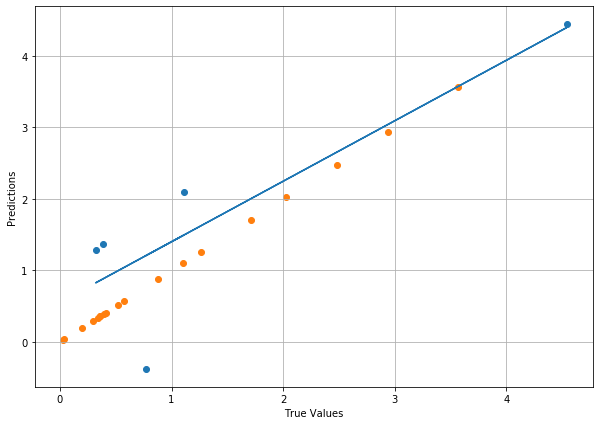

In [106]:
# Define PLS object
pls = PLSRegression(n_components=18)
# Fit
pls.fit(Xm_train, y_train)

y_pred = pls.predict(Xm_test)
y_pred1 = pls.predict(Xm_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Savgol filter

In [80]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1446) (19, 1)
(5, 1446) (5, 1)


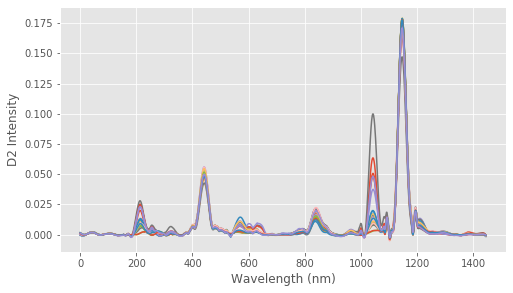

100% completed
Suggested number of components:  3



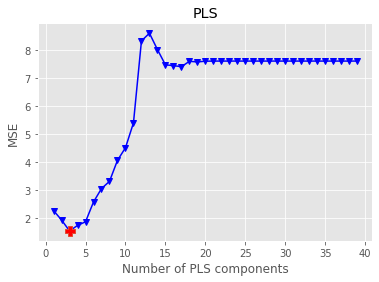

R2 calib: 0.476
R2 CV: -0.131
MSE calib: 0.716
MSE CV: 1.544


In [81]:
# Calculate second derivative
X2 = savgol_filter(x_df, 101, polyorder = 6,deriv=0) # Is this useful with LIBS spectra???
# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(range(len(X2.T)), X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Intensity')
    plt.show()
    
    
X2_1 = msc(X2)[0]
    
optimise_pls_cv(X2_1, y_df, 40, plot_components=True)

100% completed
Suggested number of components:  2



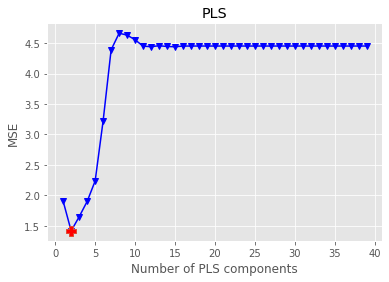

R2 calib: 0.620
R2 CV: -0.120
MSE calib: 0.481
MSE CV: 1.417


In [86]:
X2_train = savgol_filter(X_train, 37, polyorder = 4,deriv=1) 
X2_test = savgol_filter(X_test, 35, polyorder = 4,deriv=1) 




optimise_pls_cv(X2_train, y_train, 40, plot_components=True)

R2_pred:  -0.4142851041406448
R2_cv:  -0.502517109222492

[real, predictions]
[[ 0.339      -0.72308828]
 [ 3.57        0.70202523]
 [ 0.2         0.71243987]
 [ 0.293       1.80524588]
 [ 0.363      -0.11310216]]


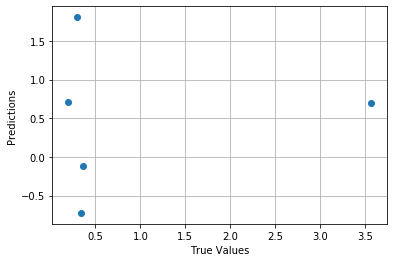

In [87]:
# Define PLS object
pls = PLSRegression(n_components=4)
# Fit
pls.fit(X2_train, y_train)

y_pred = pls.predict(X2_test)

# Cross-validation
y_cv = cross_val_predict(pls, X2_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Elastic Net

In [107]:
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.15)

alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

In [116]:
for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.86, MSE:2.00, RMSE:1.41
Alpha:0.0010, R2:0.86, MSE:2.00, RMSE:1.41
Alpha:0.0100, R2:0.86, MSE:2.00, RMSE:1.41
Alpha:0.1000, R2:0.86, MSE:1.97, RMSE:1.40
Alpha:0.3000, R2:0.87, MSE:1.92, RMSE:1.39
Alpha:0.5000, R2:0.87, MSE:1.90, RMSE:1.38
Alpha:0.7000, R2:0.87, MSE:1.96, RMSE:1.40
Alpha:1.0000, R2:0.86, MSE:2.04, RMSE:1.43


Train score:  0.8633761850956385
RMSE:  1.4142358091641216
R^2_pred:  0.20149008284994485 



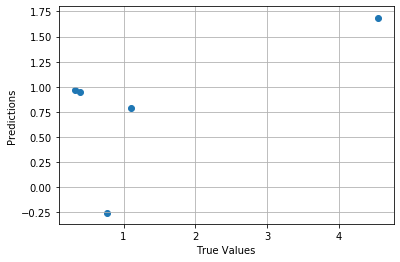

In [117]:
model = ElasticNet(alpha=0.0001).fit(X_train,y_train)   
score = model.score(X_train, y_train)
print("Train score: ", score)
pred_y = model.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, pred_y))
r2 = r2_score(y_test, pred_y)
print("RMSE: ", rmse)
print("R^2_pred: ", r2, "\n")

plt.scatter(y_test, pred_y)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Random Forest

In [113]:
#X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.15)
#X_train, X_test, y_train, y_test = train_test_split(principalComponents, y_df, test_size=0.15)
X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3
#X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.15)


print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(y_test)

(19, 26) (19, 1)
(5, 26) (5, 1)


In [114]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(5,)
(19,)


RMSE:  1.6945507325953322
R^2:  -0.14642541726395097 

[real, predictions]
[[1.11      0.6440152]
 [0.32      0.4632668]
 [0.39      0.4480108]
 [4.54      0.8034982]
 [0.77      1.163742 ]]


Text(0, 0.5, 'Predictions')

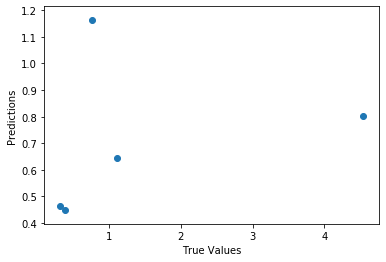

In [115]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 5000, max_depth=30, random_state = 42)
# Train the model on training data

rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("RMSE: ", rmse)
print("R^2: ", r2, "\n")

y_test= y_test.reshape((len(y_test), 1))
predictions=predictions.reshape((len(y_test), 1))
#print((y_test, predictions))

b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# MultiOutput Random Forest

In [58]:
multi_y = concentration[:,1:-2]
print (multi_y.shape)
print (type(multi_y))
df_y= pd.DataFrame(multi_y)
print (type(df_y))
df_y

(24, 6)
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5
0,0.185,0.228,2.940,0.0304,0.0620,0.280
1,0.360,0.600,1.100,0.0700,0.2000,0.830
2,9.140,1.010,0.200,0.4200,3.6000,0.410
3,8.565,0.000,0.293,0.8870,2.6360,0.330
4,9.500,0.000,0.391,0.0000,0.0580,0.016
5,7.220,0.140,0.360,0.0840,0.1200,0.053
6,7.460,0.530,0.036,0.1400,0.1500,0.100
7,12.900,0.120,0.520,0.1550,0.5200,0.286
8,8.750,0.460,1.710,0.0290,2.0000,0.056
9,0.260,0.420,1.260,0.0200,0.0040,1.160


In [59]:
X_train, X_test, y_train, y_test = train_test_split(x_df, df_y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(x_selecta, df_y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 92) (19, 6)
(5, 92) (5, 6)


In [60]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=650,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=30,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=650,
                                                

In [61]:
y_multirf = regr_multirf.predict(X_test)

In [62]:
print(y_test.shape)
print(y_multirf.shape)

(5, 6)
(5, 6)


In [63]:
rmse = sqrt(mean_squared_error(y_test, y_multirf))
r2 = r2_score(y_test, y_multirf)

print("R^2: ", r2)
print("RMSE: ", rmse)

R^2:  -22.914872834254144
RMSE:  2.9557955328081205


In [64]:
b=np.append(np.around(y_test,3), np.around(y_multirf,3), axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[ 0.07   0.1    0.41   0.18   0.06   1.45   1.126  0.337  2.025  3.652
   1.503  0.233]
 [ 9.14   1.01   0.2    0.42   3.6    0.41   7.358  0.114  0.366  0.146
   0.638  0.16 ]
 [ 0.18   0.5    1.11   0.052  0.15   1.26   6.229  0.115  0.54   0.154
   0.54   0.249]
 [ 8.75   0.46   1.71   0.029  2.     0.056  0.834  0.355  1.538  0.674
   0.719  0.452]
 [12.9    0.12   0.52   0.155  0.52   0.286  1.839  0.594  1.024  0.769
   2.365  0.119]]


Text(0, 0.5, 'Predictions')

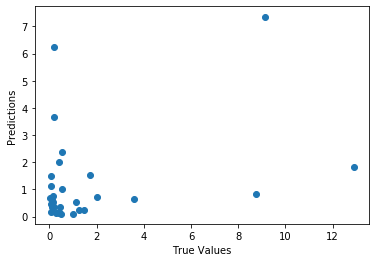

In [65]:
plt.scatter(y_test, y_multirf)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [68]:
print("real: ", y_test[0].values)
print("pred: ", y_pred[:,0])

real:  [ 0.07  9.14  0.18  8.75 12.9 ]
pred:  [1.13 7.36 6.23 0.83 1.84]


# PLS-2

75% completed
Suggested number of components:  1



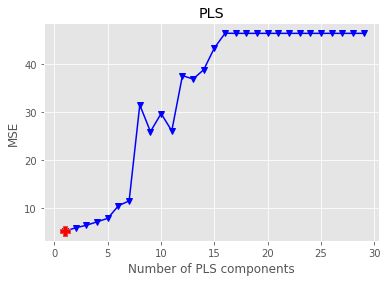

R2 calib: 0.067
R2 CV: -0.186
MSE calib: 4.597
MSE CV: 5.324


In [77]:
optimise_pls_cv(X_train, y_train, 30, plot_components=True)

In [78]:
# Define PLS object
pls = PLSRegression(n_components= 36)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ",score_pred) #NAMMERDA
print(score_cv)

R2_pred:  -225.89114262553662
-14.272392328824807


In [79]:
pd.DataFrame(np.round(y_pred, decimals=2))

,0,1,2,3,4,5
0,7.83,0.24,3.53,2.56,0.82,-0.26
1,-0.51,0.54,0.78,0.15,3.38,0.30
2,1.88,0.95,1.14,1.84,2.81,0.23
3,-1.20,0.25,6.43,3.71,0.06,0.46
4,2.13,-0.05,3.31,1.70,0.24,-0.38


In [80]:
np.round(y_test, decimals=2)

,0,1,2,3,4,5
9,0.26,0.42,1.26,0.02,0.00,1.16
6,7.46,0.53,0.04,0.14,0.15,0.10
20,6.16,0.00,0.36,0.00,0.01,0.21
11,0.16,0.31,0.88,0.10,0.11,1.14
16,3.00,0.80,0.57,0.15,4.29,0.04
